# 2-Cell and 3-Cell Motifs in PyC Subgraph (Th=100, with Proximity Constraints)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

### 1. Create PyC Subgraph and Load Proximity Model

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th100 = get_thresholded_graph(g_actual, axls, 100)
print(nx.info(g_th100))

Name: 
Type: DiGraph
Number of nodes: 111
Number of edges: 659
Average in degree:   5.9369
Average out degree:   5.9369


In [6]:
# load precomputed proximity data and plot
prox_th100 = pd.read_csv('saved/proximity_th100_avg10um.csv')

### 2. Compare 2-Cell Motif Statistics (OBS vs ER vs PM)

In [7]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_th100)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_th100)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.65 ms


In [8]:
%%time
# sample graphs from PM model and compute 2-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
proximity_two_counts = sample_motifs_parallel_proximity(proximity_sample_two_neuron_motifs, g_th100, samples=s, 
                                                     ps=prox_th100["p_connect"], edge_order=prox_th100["edge_order"], 
                                                     threads=10)

CPU times: user 88 ms, sys: 52 ms, total: 140 ms
Wall time: 7.69 s


In [25]:
# save sampled motif counts from PM as intermediate data
proximity_two_counts.to_csv("saved/th100_2motif_pm1000.csv", index=False)

In [26]:
# load precomputed sampled motif counts from CFG model
proximity_two_counts = pd.read_csv("saved/th100_2motif_pm1000.csv")

connect probability =  0.05397215397215397


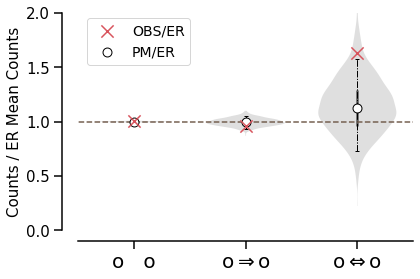

In [16]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, proximity_two_counts, ylim=(0, 2), cfg_name="PM", fname="th100/proximity_th100_2_violin");

In [17]:
res_two

,obs,er_exp,proximity_exp,proximity_std,proximity_z
actual_edges,NaN,NaN,661.427,24.262756,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,29.0,17.783825,20.442,4.610411,1.856234
neurons,NaN,NaN,111.000,0.000000,NaN
null,5475.0,5463.783825,5464.015,23.056026,0.476448
potential_edges,NaN,NaN,12210.000,0.000000,NaN
uni,601.0,623.432351,620.543,22.737439,-0.859508


In [18]:
# p-values
np.minimum((proximity_two_counts >= obs_two_counts).sum(0) / 1000, 
           (proximity_two_counts <= obs_two_counts).sum(0) / 1000)

neurons            1.000
autapses           1.000
actual_edges       0.475
uni                0.202
bi                 0.044
potential_edges    1.000
null               0.321
dtype: float64

### 3. Compare 3-Cell Motif Statistics (OBS vs ER vs PM)

In [19]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_th100), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_th100)
er_three_counts = compute_expected_three_neuron_motifs(g_th100, three_pr)

CPU times: user 14.9 s, sys: 192 ms, total: 15.1 s
Wall time: 15.1 s


In [22]:
%%time
# sample graphs from PM model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
proximity_three_counts = sample_motifs_parallel_proximity(proximity_sample_three_neuron_motifs, g_th100, samples=s, 
                                                          ps=prox_th100["p_connect"], edge_order=prox_th100["edge_order"], threads=10)

CPU times: user 120 ms, sys: 88 ms, total: 208 ms
Wall time: 1h 23s


In [27]:
# save sampled motif counts from PM model as intermediate data
proximity_three_counts.to_csv("saved/th100_3motif_pm1000.csv", index=False)

In [28]:
# load precomputed sampled motif counts from PM model
proximity_three_counts = pd.read_csv("saved/th100_3motif_pm1000.csv")
proximity_three_counts.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

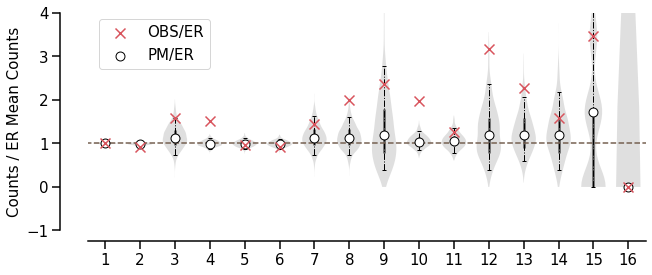

In [29]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, proximity_three_counts, 
                                            subtitle='', ylim=[-1, 4], cfg_name="PM", fname="th100/proximity_th100_3_violin", figsize=(10,4))

In [30]:
res_three

,obs,er_exp,proximity_exp,proximity_std,proximity_z
1,161442,159006.336277,159099.218,2009.478269,1.165866
2,50074,54429.144978,54060.130,1541.953421,-2.585117
3,2478,1552.627761,1779.591,400.136843,1.745425
4,2362,1552.627761,1547.111,112.633054,7.234901
5,1509,1552.627761,1548.101,115.562318,-0.338354
6,2854,3105.255523,3090.630,217.635149,-1.087278
7,255,177.158981,204.135,47.600279,1.068586
8,353,177.158981,203.832,47.931839,3.112086
9,12,5.053578,6.730,4.014625,1.312700
10,352,177.158981,186.778,24.753089,6.674803


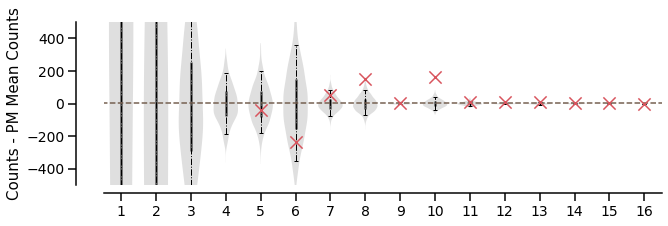

In [32]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, proximity_three_counts, 
                                     subtitle='', ylim=[-500, 500], cfg_name="PM", fname="th100/proximity_th100_3_violin_diff");

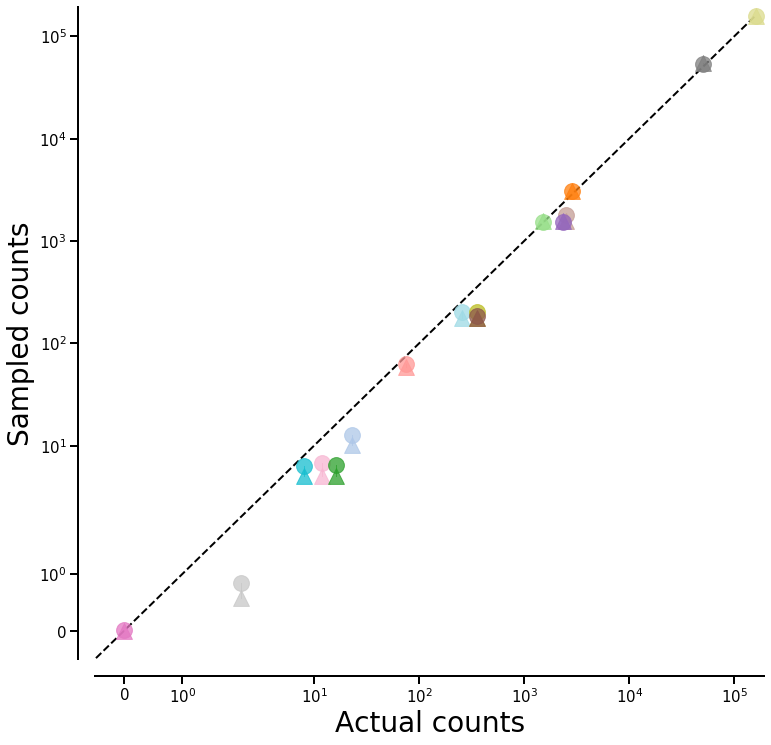

In [33]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, proximity_three_counts, figsize=(12,12), fname="th100/proximity_th100_3_scatter")

In [34]:
# p-values
np.minimum((proximity_three_counts >= obs_three_counts).sum(0) / 1000, 
           (proximity_three_counts <= obs_three_counts).sum(0) / 1000)

1     0.116
2     0.003
3     0.045
4     0.000
5     0.380
6     0.142
7     0.153
8     0.002
9     0.116
10    0.000
11    0.131
12    0.010
13    0.033
14    0.318
15    0.208
16    0.993
dtype: float64

### 4. Compare 3-Cell Motif Statistics (OBS vs gER vs PM)

In [35]:
%%time
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th100)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_th100, three_pr_GE)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 761 µs


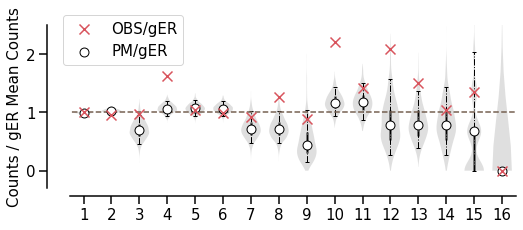

In [36]:
# relative counts in ratio (/ER expected counts)
res_three_CGE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, proximity_three_counts, 
                                            subtitle='', ylim=[-0.3, 2.5], cfg_name="PM", er_name="gER", fname="th100/proximity_th100_3_violin_CGE", figsize=(8,3))

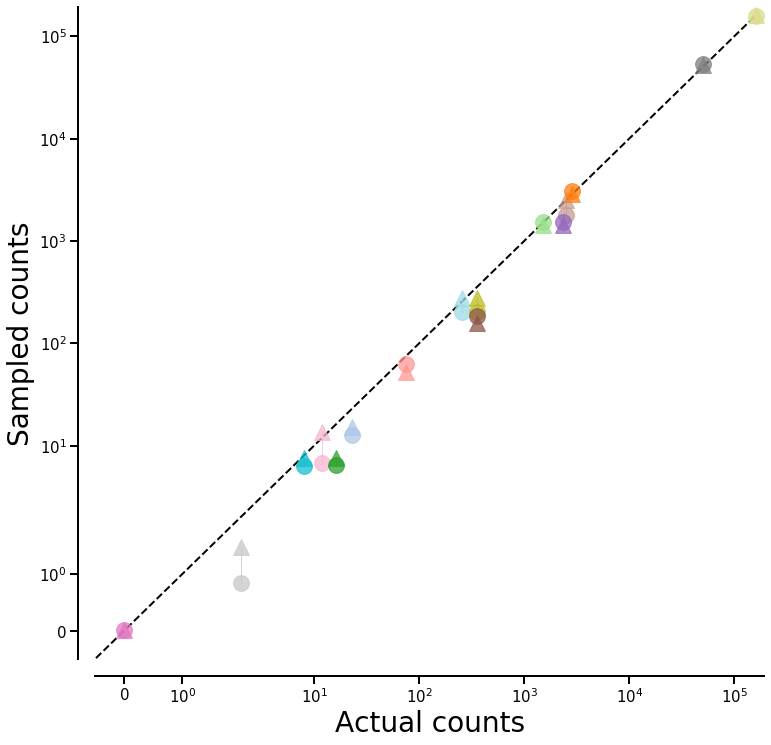

In [37]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, proximity_three_counts, 
                                 figsize=(12,12), fname="th100/proximity_th100_3_scatter_CGE")

### 5. Clustering Coefficient

In [38]:
# clustering coefficient of the observed network
nx.transitivity(g_th100.to_undirected())

0.16277214179870056

In [39]:
# expected clustering coefficient of the networsk sampled from the PM model
clustering_coef(proximity_three_counts).mean()

0.11097358217415874

In [40]:
# p-value: PM vs OBS
(clustering_coef(proximity_three_counts) >= nx.transitivity(g_th100.to_undirected())).sum()/1000

0.0

### 6. Explain PM 2-Cell Motif Statistics

In [44]:
th100_biedge = get_bidirectional(g_th100.edges()).copy()
th100_uniedge = get_unidirectional_only(g_th100.edges()).copy()
all_edges = nx.complete_graph(g_th100.nodes(), nx.DiGraph()).edges()
edge_order_rindex = prox_th100["edge_order"].argsort()

p_connect = {"uni":[], "bi": [], "null": []}
somo_dist = {"uni":[], "bi": [], "null": []}

for i, e in enumerate(all_edges):
    if e in th100_uniedge: key = "uni"
    elif e in th100_biedge: key = "bi"
    else: key = "null"
    p_connect[key].append(prox_th100["p_connect"][edge_order_rindex][i])
    somo_dist[key].append(prox_th100["soma_dist"][edge_order_rindex][i])

In [49]:
# report mean connection probability and mean distance
for k in p_connect.keys():
    print(k, np.mean(p_connect[k]), np.mean(somo_dist[k]))

uni 0.06115974139792533 80.01782949023273
bi 0.06996724988629167 59.28772732783656
null 0.05372525120462862 99.8477673783261


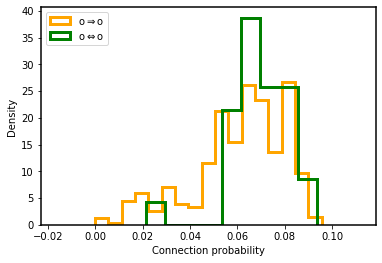

In [51]:
f, ax = plt.subplots(1, 1, figsize=(6,4))
sns.distplot(p_connect["uni"], ax=ax, rug=False, rug_kws={"color": "orange"},
                     kde_kws={"color": "orange", "lw": 3, "alpha": 0.0},
                     hist_kws={"histtype": "step", "linewidth": 3,
                                        "alpha": 1, "color": "orange", 'label':"o$\Rightarrow$o"})
sns.distplot(p_connect["bi"], ax=ax, rug=False, rug_kws={"color": "green"},
                     kde_kws={"color": "green", "lw": 3, "alpha": 0.0},
                     hist_kws={"histtype": "step", "linewidth": 3,
                                        "alpha": 1, "color": "green", 'label':"o$\Leftrightarrow$o"})
ax.set_xlabel("Connection probability")
ax.set_ylabel("Density")
ax.legend()
f.savefig("figures/th100/proximity_th100_somadist_p_bi_uni.pdf", bbox_inches='tight')
plt.show()

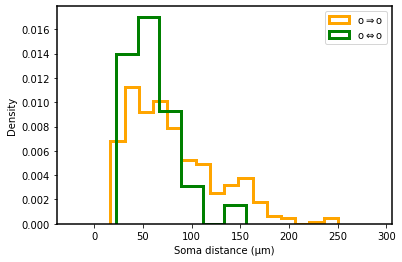

In [52]:
f, ax = plt.subplots(1, 1, figsize=(6,4))
sns.distplot(somo_dist["uni"], ax=ax, rug=False, rug_kws={"color": "orange"},
                     kde_kws={"color": "orange", "lw": 3, "alpha": 0.0},
                     hist_kws={"histtype": "step", "linewidth": 3,
                                        "alpha": 1, "color": "orange", 'label':"o$\Rightarrow$o"})
sns.distplot(somo_dist["bi"], ax=ax, rug=False, rug_kws={"color": "green"},
                     kde_kws={"color": "green", "lw": 3, "alpha": 0.0},
                     hist_kws={"histtype": "step", "linewidth": 3,
                                        "alpha": 1, "color": "green", 'label':"o$\Leftrightarrow$o"})
ax.set_xlabel("Soma distance (μm)")
ax.set_ylabel("Density")
ax.legend()
f.savefig("figures/th100/proximity_th100_somadist_bi_uni.pdf", bbox_inches='tight')
plt.show()